# Supervised Learning, Part 2 

This module focuses on a particular class of supervised machine learning: classification, where we have a finite number of choices to label an observation. 

Goals for this module:
* Exposure to the [`scikit-learn` toolbox](https://scikit-learn.org/stable/index.html) 
* Decision Trees
* Learning Curves
* Model Evaluation


In [21]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import graphviz  # visualize the decision tree 

In [22]:
np.random.seed(5550)    # Set seed for reproducibility of notebook

### Example: Wine Data 



In [23]:
from sklearn import datasets # import standard datasets
wine = datasets.load_wine() # load wine data set
print ("No of samples and features in wine datasets is {} and {} respectively".
       format(wine.data.shape[0], wine.data.shape[1]))
print("wine: ", wine.target_names)

No of samples and features in wine datasets is 178 and 13 respectively
wine:  ['class_0' 'class_1' 'class_2']


## Review

We ended last time, by training Knearest neighbors classifiers on the iris dataset.  Today we will explore the wine data set using additional classifiers: decision trees and support vector machines. 


In [24]:
from sklearn import neighbors # functions related to KNN model
from sklearn import tree      # functions related to DT model 
from sklearn import svm       # functions related to SVM model 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV

### Basics of the API 

Most commonly, the steps in using the Scikit-Learn estimator API are as follows
(we will step through a handful of detailed examples in the sections that follow).

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

We will now step through a simple examples of applying supervised learning methods.

In [25]:
# Form data into features matrix - X_train, X_test 
#  and target/label vector - y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=10)
# note: test_size is a number between 0 and 1,
# random_state is the seed used by the random number generator.  
# Here, I've fixed it to 10 for reproducibility

# Select the model and hyperparameters 
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)

# Train the classifier using the training data
knn.fit(X_train, y_train)

# Apply the model to test data
predict  = knn.predict(X_test)

from sklearn.metrics import accuracy_score
print("accuracy = %g " % (accuracy_score(y_test, predict)))

accuracy = 0.648148 


## Decision Trees 

Let's learn about decision trees (DT).  DTs are a popular method for various machine learning tasks because 
* they are invariant under scaling and various other transformation of feature values (i.e. normalization not needed)
* one can include irrelevant features without affecting the final outcome
* can handle both numerical and categorical data 
* the final outcome is easy to understand / interpret / visualized. 

DT have various downsides however:
* prone to over-fitting (overly-complex trees)
* unstable: small variations in data might result in a completely different generated tree
* optimal decision trees are NP-complete; hence, most algorithms are based on heuristic  algorithms

 

### How is a tree built?

The general approach is to split a set of samples into subsets based on attributes, and repeating the process in a recursive manner.  The simplest algorithm is a top-down, greedy search through the space of possible decision trees.


You need to determine what variable to next split on in the tree construction.  
One metric used in construction is *entropy*, a measure of uncertainty in the data set, 
$$ H(S) = \sum_{c \in C} -p(c) \log_2{p(c)}.$$
Here,
* $S$ is the current sample set for which entropy is being calculated
* $C$ is the set of classes in $S$
* $p(c)$ is the probability of encountering element in class $c$ in the set $S$.

For a binary classification problem:
* an entropy will be zero if all samples are either true, or if all samples are false.
* if half the samples are true, half the samples are false, then the entropy will be one (i.e. high).

The greedy algorithm proceeds as follows:
* compute entropy of parent
* for each feature/attribute
    * compute information gain:  Entropy(parent) - Weighted Sum of Entropy(Children).
* pick feature that gives largest information gain.

This is then repeated recursively for each leaf in the tree.  [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain.) has a nice example for a toy data set with four attributes / 14 data points.    *Note*, while the example above using entropy other measures can be used when constructing decision trees. 

Scikit-learn uses a hierarchical approach known as CART (Classification and Regression Trees). The main difference, is the Gini Index is used as the default function to evaluate splits in the data set.  It is beyond the scope of this course to explore CART and it's variants.  Interested readers should look at the collection: "The Top Ten Algorithms in Data Mining", edited by Wu and Kumar. A PDF of the relevant chapter appears to presently be posted at: http://www.uta.edu/faculty/rcli/Teaching/math6310/materials/Ten.pdf#page=192


We can create our first decision tree using the same basic structure of calling `scikit-learn` functions, but changing the model to be used from the KNN to a Decision Tree.

In [26]:
# import graphviz

# Using the wine data from above 

# Select the model and hyperparameters 
dt = tree.DecisionTreeClassifier(max_depth=3)

# Train the classifier using the training data
dt.fit(X_train, y_train)

# Apply the model to test data
predict  = dt.predict(X_test)

print("accuracy = %g " % (accuracy_score(y_test, predict)))

accuracy = 0.833333 


What does a tree look like?

### Visualize a Decision Tree 

We can visualize the tree that was learned using several different presentations. 

#### Text Representation

In [27]:
text_rep = tree.export_text(dt)
print(text_rep)

|--- feature_12 <= 787.50
|   |--- feature_9 <= 4.02
|   |   |--- class: 1
|   |--- feature_9 >  4.02
|   |   |--- feature_10 <= 1.00
|   |   |   |--- class: 2
|   |   |--- feature_10 >  1.00
|   |   |   |--- class: 1
|--- feature_12 >  787.50
|   |--- feature_6 <= 2.17
|   |   |--- feature_12 <= 883.00
|   |   |   |--- class: 2
|   |   |--- feature_12 >  883.00
|   |   |   |--- class: 1
|   |--- feature_6 >  2.17
|   |   |--- feature_4 <= 135.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  135.50
|   |   |   |--- class: 1



#### Plot Tree

We can also use the plot tree method.  Note, this function requires `matplotlib` 

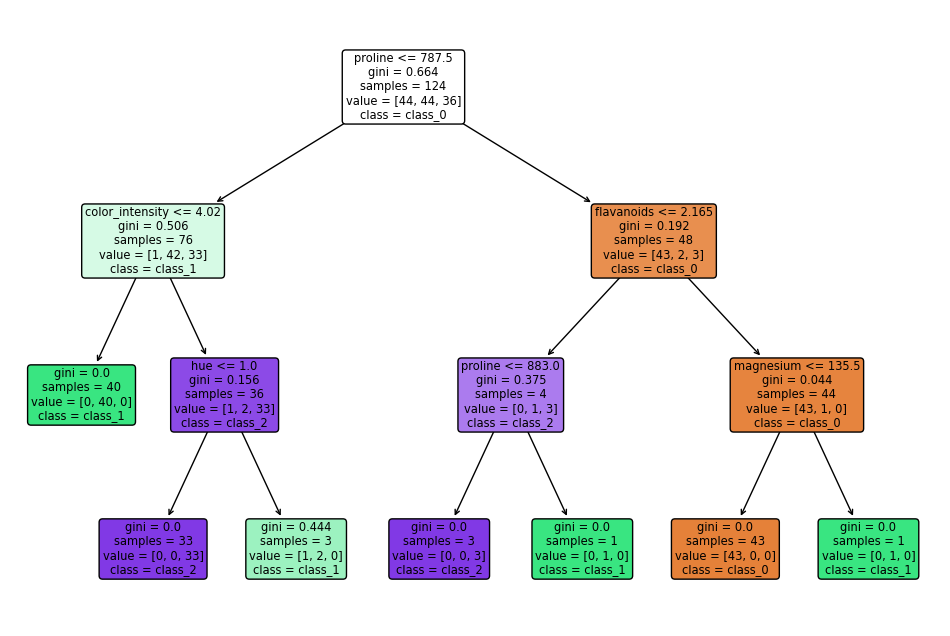

In [28]:
fig = plt.figure(figsize=(12,8))
_ = tree.plot_tree(dt, 
                   feature_names=wine.feature_names,  
                   class_names=list(wine.target_names),
                   rounded=True,
                   filled=True)

#### Graphviz 

You can also use the `export_graphviz` function.  Note, you most have `graphviz` installed on your machine (`conda install python-graphviz`) and the ability to run `dot`.  

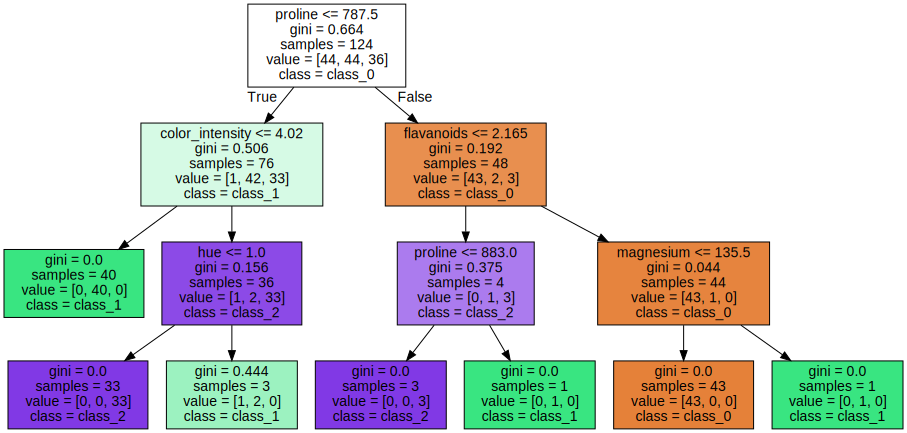

In [29]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=wine.feature_names,  
                                class_names=wine.target_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

How to read this tree? 
* top entry in each non-leaf node gives the condition being tested.  
where, gini: is a measure of impurity; how often an randomly chosen element from the set would be incorrectly labeled, 
* samples: number of samples in each node
* value: number of samples of each type
* class: the targeted output

## Learning Curves

Denote the training error (i.e. in-sample error) as $E_{in}$, i.e., the error in the model measured over all data in the *training* set.   Denote the testing error (i.e. out-of sample error / generalization error) as $E_{out}$, i.e., the error expected on unseen data.  Some intuitive statements:
* $E_{out} \ge E_{in}$
* want $E_{in} \to 0$
* want $E_{out} \approx E_{n}$, i.e.,
$\quad  E_{in} \le E_{out} \le E_{in} + \Omega, \quad \text{with } \Omega \to 0,$ where $\Omega$ typically depends on the number of samples $N$, complexity of the model, ...

Learning curve: shows relationship between training/test errors as a function of ML problem parameters.  We'll use the Decision Tree classifier which seems to work best for this problem.  Additionally, we will control the maximum depth of the tree, in some sense, controlling the complexity of the ML algorithm.  We start with a tree of just depth of 1.

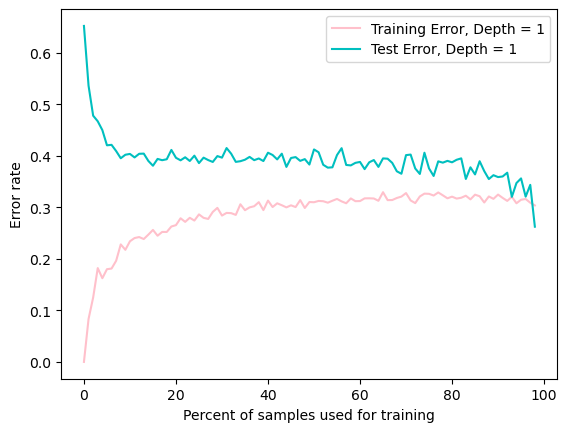

In [30]:
dt = tree.DecisionTreeClassifier(max_depth=1)

Ein = np.zeros((99,40))
Eout = np.zeros((99,40))

for nratio in range(99):

    ratio = 1 - (nratio+1)/100.0
    for i in range(40):
        # split the data
        X_train, X_test, y_train, y_test = train_test_split(
            wine.data, wine.target, test_size=ratio)

        # train the classifier using the training data
        dt.fit(X_train, y_train)

        # compute the prediction of the test set using the model
        yhat_train = dt.predict(X_train)
        yhat_test = dt.predict(X_test)

        Ein[nratio][i] = 1 - accuracy_score(y_train, yhat_train)
        Eout[nratio][i] = 1 - accuracy_score(y_test, yhat_test)
    
p1,=plt.plot(np.mean(Ein[:,:].T,axis=0),'pink')
p2,=plt.plot(np.mean(Eout[:,:].T,axis=0),'c')
fig = plt.gcf()
#fig.set_size_inches(12,5)
plt.xlabel('Percent of samples used for training')
plt.ylabel('Error rate')
_ = plt.legend([p1,p2],["Training Error, Depth = 1","Test Error, Depth = 1"])    


Observations:
* both curves tend to plateau, at a nonzero error. 
* with few samples for training, smaller training error ($E_{in}$), larger testing error ($E_{out}$). 


Let's repeat this analysis with a more complicated model (increasing depth of tree permitted).

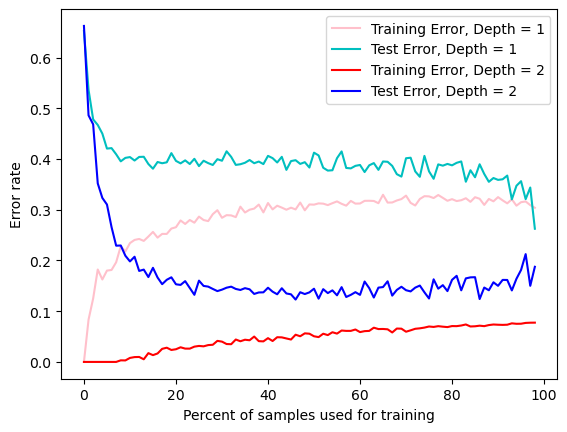

In [31]:
dt = tree.DecisionTreeClassifier(max_depth=2)

# precomputed from above execution block
p1,=plt.plot(np.mean(Ein[:,:].T,axis=0),'pink')
p2,=plt.plot(np.mean(Eout[:,:].T,axis=0),'c')

Ein = np.zeros((99,40))
Eout = np.zeros((99,40))

for nratio in range(99):

    ratio = 1 - (nratio+1)/100.0
    for i in range(40):
        # split the data
        X_train, X_test, y_train, y_test = train_test_split(
            wine.data, wine.target, test_size=ratio)

        # train the classifier using the training data
        dt.fit(X_train, y_train)

        # compute the prediction of the test set using the model
        yhat_train = dt.predict(X_train)
        yhat_test = dt.predict(X_test)

        Ein[nratio][i] = 1 - accuracy_score(y_train, yhat_train,)
        Eout[nratio][i] = 1 - accuracy_score(y_test, yhat_test)
    
p3,=plt.plot(np.mean(Ein[:,:].T,axis=0),'red')
p4,=plt.plot(np.mean(Eout[:,:].T,axis=0),'blue')
fig = plt.gcf()
#fig.set_size_inches(12,5)
plt.xlabel('Percent of samples used for training')
plt.ylabel('Error rate')
_ = plt.legend([p1,p2,p3,p4],["Training Error, Depth = 1","Test Error, Depth = 1",
                              "Training Error, Depth = 2","Test Error, Depth = 2"])  

These graphs are not as instructive as those in your textbook, since we are working with the wine data set, rather than the toy problem generated on page 79. Some terms:

* the training and test errors often converge for each ML model. The value it converges to is known as the bias. Here the curves have not converged, which is often the case when there are insufficient samples.
* the difference between the bias and the test error is known as the variance.

## Overfitting 

If one creates a learning curve for a fixed number of data samples, but increase the complexity of the model, one often observes the following behavior. (We'll use the data from the textbook since we don't really have enough samples to see such a curve in the wine data set).

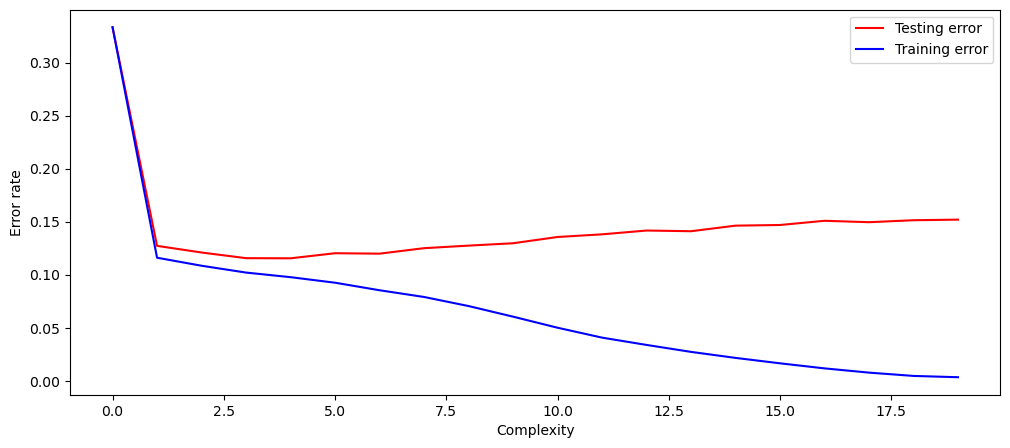

In [32]:
# from sklearn import metrics

MAXC=20
N=1000
NTEST=4000
ITERS=3

yhat_test=np.zeros((ITERS,MAXC,2))
yhat_train=np.zeros((ITERS,MAXC,2))

#Repeat ten times to get smooth curves
for i in range(ITERS):
    X = np.concatenate([1.25*np.random.randn(N,2),5+1.5*np.random.randn(N,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(N,2)])
    y = np.concatenate([np.ones((N,1)),-np.ones((N,1))])
    y = np.concatenate([y,np.ones((N,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(NTEST,2),5+1.5*np.random.randn(NTEST,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(NTEST,2)])
    y_test = np.concatenate([np.ones((NTEST,1)),-np.ones((NTEST,1))])
    y_test = np.concatenate([y_test,np.ones((NTEST,1))])

    j=0
    for C in range(1,MAXC+1):
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(X,y.ravel())
        yhat_test[i,j,0] = 1. - metrics.accuracy_score( y_test.ravel(), clf.predict(X_test))
        yhat_train[i,j,0] = 1. - metrics.accuracy_score( y.ravel(), clf.predict(X))
        j=j+1

p1, = plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),'r')
p2, = plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('Complexity')
plt.ylabel('Error rate')
plt.legend([p1, p2], ["Testing error", "Training error"])
plt.savefig("learning_curve_4.png",dpi=300, bbox_inches='tight')

* Here, we see that as the complexity increases (depth of the tree is allowed to increase), the training error decreases.
* Above a certain level of complexity, the test error starts increasing.  This is known as **over-fitting**

Most models are parameterized by hyper-parameters.
* e.g., nearest neighbors: have to specify number of neighbors to use
* e.g., decision tree: have to specify depth (and other options)

A good heuristic for selecting the model is to choose the value of the hyper-parameter that yields the smallest estimated test or validation set error (test this using cross-validation).  To address over-fitting, the following approaches are also used:
* regularization: penalizing complex models
* ensemble techniques: e.g., bagging.  The idea is to generate several subsets of data from the training sample chosen randomly with replacement.

## Support Vector Machines 

Support Vector Machines (SVMs) are the third type of classifier that we will use in class. 

Hyperparameters for SVMs include select the kernel function and cost penalty parameter, $C$.  
Different [kernels](http://scikit-learn.org/stable/modules/svm.html#svm-kernels) include: linear, Gaussian (rbf), polynomial, etc. 

Let's look at a simple example of an SVM.  


In [33]:
# Using the wine data from above 
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=10)

# Select the model and hyperparameters 
clf = svm.SVC(kernel='linear', C=0.5)

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Apply the model to test data
predict  = clf.predict(X_test)

print("accuracy = %g " % (accuracy_score(y_test, predict)))

accuracy = 0.888889 


## Model Evaluation

We were left off in terms of model evaluation was using a Three-fold split approach. 

Use of three separate sets:    
* the training set for model building 
* the validation set for model selection 
* the test set for final model evaluation 
is probably the most common used method for model selection and evaluation. It is a **best practice** to follow (along with other techniques described in lab and future classes). 

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/train_test_validation_split.png" width="50%">

With this new approach, we use the validation set to select the optimum hyper-parameter and the test set to estimate the performance (accuracy).  Because the test set was not used for estimating the best hyper-parameter, the test set provides an unbiased estimate of the generalization performance. It is important to note, *the test set only provides an unbiased result if we are using it once**.  



This approach has improved upon the simple train/test set method, but still relies on the particular splits. What if we change the random splits, we might end up with different results. 

In this example we repeat the three-fold split approach 10 times, to see how the results vary over different splits of the data. 

	 Val	 Nnbr	 Test
	 0.759	1	0.750
	 0.793	9	0.667
	 0.759	3	0.667
	 0.690	3	0.694
	 0.793	11	0.722
	 0.759	3	0.611
	 0.724	13	0.806
	 0.828	1	0.750
	 0.759	5	0.694
	 0.759	3	0.694


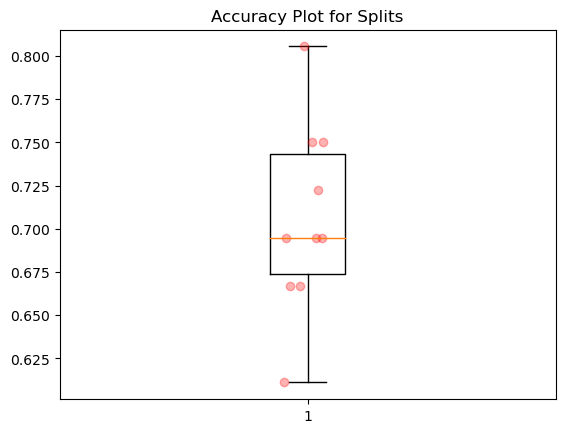

In [34]:
# Set up data for example 
X = wine.data 
y = wine.target

rstates = [5, 10, 15, 20, 25, 30, 24, 17, 6, 34]
best_test_score = np.zeros(10)
best_n_nbrs = np.zeros(10)

print("\t Val\t Nnbr\t Test")

for ri in range(len(rstates)):

    # Split of the test set 
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.20, random_state=rstates[ri])

    # Split trainval into train + val 
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.20, random_state=rstates[ri])

    # create a list to hold the perf. results on validation set 
    val_scores = [] 
    # specify hyper-parameter values 
    nbrs = np.arange(1,16,2)

    for n in nbrs: 
        # build a model 
        knn = neighbors.KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        # calculate performance on validation set 
        val_scores.append(knn.score(X_val, y_val))

    # Find the best score and best hyper-parameter 
    print("\t %.3f" % np.max(val_scores), end='')
    best_nbrs = nbrs[np.argmax(val_scores)]
    print("\t%d" % best_nbrs, end='')
    best_n_nbrs[ri] = best_nbrs

    # Retrain model on train + validation set 
    knn = neighbors.KNeighborsClassifier(n_neighbors=best_nbrs)
    knn.fit(X_trainval, y_trainval)
    test_acc = knn.score(X_test, y_test)
    print("\t%.3f" % test_acc)
    best_test_score[ri] = test_acc

fig1, ax1 = plt.subplots()
ax1.set_title('Accuracy Plot for Splits')
_ = ax1.boxplot(best_test_score) 
xderiv = np.ones(best_test_score[:].shape)+(np.random.rand(10,)-0.5)*0.1
_ = plt.plot(xderiv,best_test_score[:] ,'ro',alpha=0.3) # add a jigger plot of data points

How can we make this process more robust? 

*Cross validation*

### Cross Validation 

Cross validation is one of the most popular methods for performance estimation.  Evaluation is averaged over several folds, but avoids overlapping test sets of the repeated holdout procedure.

There are several variations of cross validation (c.v.) to consider:

* k-fold cross validation 
* leave-one-out cross validation (LOOCV)  
Given $N$ samples, model is trained with $N-1$ samples and tested with the remaining one.  This is repeated $N$ times, once per training sample, and the result is averaged.  Only should be performed on very small data sets. 
* leave p out cross validation  
Given $N$ samples, model is trained with $N-p$ samples and tested with the remaining $p$ samples.  This is repeated `choose(N, p)` times, and the result is averaged.  This approach is impractical for most choices of $n$ and $p$.
* $k_1 \times k_2$ cross validation  
Repeat $k_2$ cross validation, $k_1$ times 

We will focus on k-fold cross validation. 


#### K-fold Cross Validation 

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/cross_validation_new.png" width="50%">

The most common variant of cross-validation is k-fold cross validation, the image above illustrates a 5-fold cross-validation. 

For each fold, a split of the data is made where this fold is the validation data, and the rest is the training data.  For the 5-fold cross-validation, we split the data into five parts, and have 5 different training/validation splits.  We build a model for each of the splits using the training part and validation part to evaluate it.  The outcome is five different performance values.  These can be aggregated - compute a mean/median, or use them to estimate a variance over the splits. 

This approach is more robust over using a single split.  All of the initial train/validation data is used in the validation set exactly once, where a single split only some of the data appears in the validation set.   The main disadvantage of cross-validation is the computational cost.  

**Another issue of k-fold cross-validation is that it doesn't produce a model, it produced k models.**  If you want to make predictions on new data, how to do so?  One obvious method is to retrain on the whole train/validation set.  

#### Example of cross-validation 

There are two functions in `scikit-learn` for performing cross-validation: `cross_val_score` and `cross_validate`.  The `cross_val_score` has a very simple interface and the `cross_validate` provides more options. 

We can use them to evaluate KNN on the iris data set.  Cross-validation is usually used to replace the inner split into training and validation set.  Both functions, take the estimator to evaluate (our knn), the data, the target and the number of folds.  The result of `cross_val_score` is an array with the **accuracy** for each validation sets. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [35]:
# from sklearn.model_selection import cross_val_score, cross_validate

# Basic code for cross validation
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=7)

knn_kcv_scores = cross_val_score(
    knn_clf, X_trainval, y_trainval, cv=10)

knn_kcv_scores

array([0.93333333, 0.93333333, 0.64285714, 0.71428571, 0.57142857,
       0.71428571, 0.71428571, 0.57142857, 0.71428571, 0.64285714])

We can also use `cross_validate`.  Here the result is a dictionary. 

In [36]:
# the number of folds defaults to 5
cv_result = cross_validate(knn_clf, X_trainval, y_trainval)
cv_result

{'fit_time': array([0.00038385, 0.00028372, 0.00028944, 0.00027037, 0.00031209]),
 'score_time': array([0.00114918, 0.00107813, 0.00103426, 0.00105619, 0.00102687]),
 'test_score': array([0.86206897, 0.62068966, 0.67857143, 0.75      , 0.71428571])}

In [37]:
# We can convert the dictionary to a Data Frame 
pd.DataFrame(cv_result)

,fit_time,score_time,test_score
0,0.000384,0.001149,0.862069
1,0.000284,0.001078,0.620690
2,0.000289,0.001034,0.678571
3,0.000270,0.001056,0.750000
4,0.000312,0.001027,0.714286


Both `cross_val_score` and `cross_validate` can use other evaluation metrics. 

We can also do this process by hand, i.e., using the `KFold()` family of methods. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [38]:
# from sklearn.model_selection import StratifiedKFold 

# Continue to use the wine data 

# Set up 10 different splits
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=124)

scores = []

# loop through the splits
for tr_indx, val_indx in kf.split(X_trainval, y_trainval):
    X_train, X_val = X_trainval[tr_indx], X_trainval[val_indx]
    y_train, y_val = y_trainval[tr_indx], y_trainval[val_indx]

    knn = neighbors.KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    scores.append(metrics.accuracy_score(y_val, y_pred))

print("mean validation score:  %.3f" % np.mean(scores))

mean validation score:  0.676


### Grid Search with Cross-Validation

Let's now think about doing model selection, but using cross-validation rather than a single split.  The overall idea is illustrated below. We still have the initial split into training and test data.  But rather than a single split into training and validation data, we run cross-validation for each parameter setting.  We record the mean score averaged over the splits in the cross-validation.  After evaluating all candidate paramters, find the one with the best mean performance.  *Keep in mind this score does not correspond to a single model; there is no best model*.  We select the hyper-parameter that is best on average over the splits.  Then we build a new model, using the hyper-parameters that performed best on average in cross-validation, on the full training dataset (X_trainval).  Finally, we evaluate this model on the test data set.   


<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/grid_search_cross_validation_new.png" width="60%">

In [39]:
# create a list to hold the perf. results on validation sets 
cross_val_scores = [] 
# specify hyper-parameter values 
nbrs = np.arange(1,16,2)

for n in nbrs: 
    # build the model with hyper-parameters 
    knn = neighbors.KNeighborsClassifier(n_neighbors=n)
    # Instead of fitting a single model, we perform cross-validation 
    scores = cross_val_score(knn, X_trainval, y_trainval, cv=10)
    # record the average over the 10 folds 
    cross_val_scores.append(np.mean(scores))

print(f"best cross-validation score: {np.max(cross_val_scores):.3}")
best_nbrs = nbrs[np.argmax(cross_val_scores)]
print(f"best n_neighbors: {best_nbrs}")

knn = neighbors.KNeighborsClassifier(n_neighbors=best_nbrs)
knn.fit(X_trainval, y_trainval)
print(f"test-set score: {knn.score(X_test, y_test):.3f}")

best cross-validation score: 0.745
best n_neighbors: 1
test-set score: 0.806


The code above of grid-search with cross-validation and a hold-out test set is a gold standard approach for model comparison and parameter tuning.  

**ASIDE: Cross-validation vs. Grid Search** 

Students over conflate the use of cross-validation with the use of grid search.  These are distinct and should not be used interchangeably.  Cross-validation is a technique to robustly evaluate a particular model on a particular data set.  Grid search is a technique to tune the hyper-parameters of a particular model by brute-force search.  Often each candidate is evaluated using cross-validaiton, but it is not necessary (you could use a single split of training + validation set).  So while cross-validation is often used within a grid search, you can also do cross-validation outside of a grid search, and you can do a grid search without using cross-validation.

The overall approach is illustrated below.  Start by specifying hyper-parameters to evaluate (generally this means selecting the models we are using as well).  Split the data into training and test sets.  For each hyper-parameter candidate, run a grid search on the training set, yielding a score for each split, and a mean score over all splits.  The mean validation scores are used to select the best hyper-parameter value and retrain a model on the whole training data.  Then we evaluate this final model on the test set. 


<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/gridsearch_workflow.png" width="60%">
Image from scikit-learn.

<br>

This pattern of evaluation is common, therefore, `scikit-learn` has a method `GridSearchCV`, which does most of this for you. 


### GridSearchCV 

The `GridSearchCV` class is a meta-estimator, it takes any scikit-learn model and tunes the hyper-parameters for you using cross-validation.  The hyper-parameter grid is specified as a dictionary where the keys are the names of the parameters in the estimator and the values are all the candidate values of the hyper-parameter we want to evaluate.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


In [40]:
# from sklearn.model_selection import GridSearchCV

# Split of the test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, 
                                                          random_state=55)

# define the parameter grid 
param_grid = {'n_neighbors': np.arange(1, 16, 2)}

# Instantiate GridSearchCV - sets up the parameters on how to run 
grid = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=10, 
                    return_train_score=True)
# Execute the search (and retrain the final model) 
grid.fit(X_trainval, y_trainval)

print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameters: {grid.best_params_}")

# do a final evaluation on the test set 
print(f"test-set score: {grid.score(X_test, y_test):.3f}")

best mean cross-validation score: 0.7109523809523809
best parameters: {'n_neighbors': 1}
test-set score: 0.750


Because grid search is a meta-estimator, after you instantiate it, you can use it like any other scikit-learn model: use `fit`, `predict`, `score` methods using the best hyper-parameter setting. 

The test set is reserved for the final evaluation, therefore, it can be a good idea to look at the search results without the test set.  If the `best_score_` is lower than expected or needed for an application, do not use the test set.  Also, you may want to look at whether the `best_params_` value is on the boundary of the search space specified.  If it is, you may want to extend the range.  Also, the model that was refit on the whole training + validation data (the model used when calling `predict` and `score`) is called as `best_estimator_`.  

The `cv_results_` attribute allow us to dive into the results. 

In [41]:
grid.cv_results_

{'mean_fit_time': array([0.00032227, 0.0003196 , 0.00031824, 0.0003109 , 0.00031574,
        0.00031476, 0.0003077 , 0.00029514]),
 'std_fit_time': array([2.93132807e-05, 1.27634130e-05, 4.48009763e-05, 1.29133982e-05,
        1.87876412e-05, 1.65647903e-05, 2.33343955e-05, 1.76672672e-05]),
 'mean_score_time': array([0.00086586, 0.00084691, 0.00083976, 0.00083063, 0.00083489,
        0.00083659, 0.00083094, 0.00081432]),
 'std_score_time': array([6.03184917e-05, 2.13984626e-05, 1.69766083e-05, 8.63750073e-06,
        1.57608206e-05, 2.06543847e-05, 2.02509322e-05, 2.05018492e-05]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9},
  {'n_neighbors': 11},
  {'n_neighbors': 13},
  {'n_neighbors': 15}],
 'split0_test_score': 

Each splits, training and testing score is returned because it was specified that `return_train_score=True`.  For a single hyper-parameter, we can plot the results.

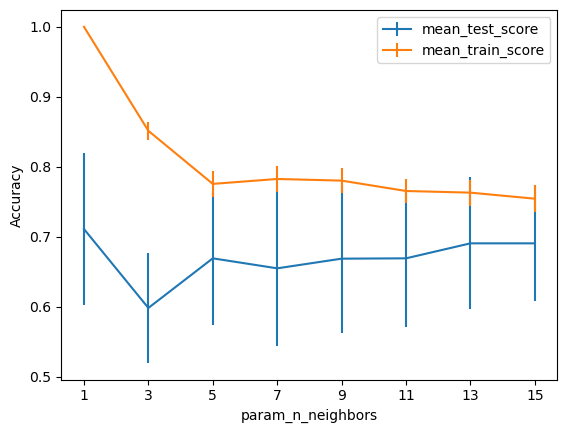

In [42]:
results = pd.DataFrame(grid.cv_results_)
ax = results.plot('param_n_neighbors', 'mean_test_score', yerr='std_test_score')
# reuse the axes from the first plot (ax=ax)
results.plot('param_n_neighbors', 'mean_train_score', yerr='std_train_score', ax=ax)
plt.ylabel('Accuracy')
plt.legend();

The wide standard deviation on the validation sets (test_score) is not suprising because of the small size of the data set. 